In [247]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from gensim.utils import simple_preprocess

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1> Read the .csv file using Pandas. Take a look at the top few records.

In [248]:
revs0 = pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course4-NLP/Projects/K8 Reviews v0.2.csv")
revs0.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with..."
2,1,when I will get my 10% cash back.... its already 15 January..
3,1,Good
4,0,The worst phone everThey have changed the last phone but the problem is still same and the amazo...


In [249]:
revs0.shape

(14675, 2)

In [250]:
revs0.sentiment.value_counts(normalize=True)
# This dataset is balanced.

0    0.52552
1    0.47448
Name: sentiment, dtype: float64

In [251]:
revs0.review.isnull()
# No null values present in the dataset.

0        False
1        False
2        False
3        False
4        False
         ...  
14670    False
14671    False
14672    False
14673    False
14674    False
Name: review, Length: 14675, dtype: bool

In [252]:
revs0.review.sample().values[0]

'Bad qualities'

In [253]:
revs1 = revs0.review.values
len(revs1)

14675

In [254]:
revs1[:5]

array(['Good but need updates and improvements',
       "Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me.",
       'when I will get my 10% cash back.... its already 15 January..',
       'Good',
       'The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing of amazon'],
      dtype=object)

The dataset contains numbers, % signs, ...., /, !, @

# 2> Normalize casings for the review text and extract the text into a list for easier manipulation.
# 7> Remove stopwords and punctuation

In [255]:
data = revs0.review.values.tolist()

# Below code will delete '.' occuring multiple times and will delete '-' occuring multiple times.Also delete emojis.

data = [re.sub(r'[.]{1,}', '', file) for file in data]
data = [re.sub(r'[--]{2}', '', file) for file in data]
data= [re.sub('[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+','',file)for file in data]

print(data[9203])

# below code will show the reviews written in different language into english.

from nltk.corpus import stopwords
def preprocess2(raw_text):
    stopword_set = set(stopwords.words("english"))
    stopword_set.discard("not")
    stopword_set.discard("no")
    stopword_set.discard("don")
    stopword_set.discard("won")
    stopword_set.discard("won't")
    stopword_set.discard("don't")
    stopword_set.discard("doesn't")
    stopword_set.discard("does")
    stopword_set.discard("doesn")
    stopword_set.discard("do")
    stopword_set.discard('wouldn')
    stopword_set.discard("wouldn't")
    stopword_set.discard('shan')
    stopword_set.discard("shan't")
    stopword_set.discard('shouldn')
    stopword_set.discard("shouldn't")
    stopword_set.discard('aren')
    stopword_set.discard("aren't")
    stopword_set.discard('couldn')
    stopword_set.discard("couldn't")
    stopword_set.discard('didn')
    stopword_set.discard("didn't")
    stopword_set.discard('mightn')
    stopword_set.discard("mightn't")
    stopword_set.discard('mustn')
    stopword_set.discard("mustn't")
    stopword_set.discard("have")
    return " ".join([i for i in re.sub(r'[^a-zA-Z\s]', "", raw_text).lower().split() if i not in stopword_set])

data = [preprocess2(raw_text) for raw_text in data]
data = ["".join(raw_text) for raw_text in data]
#revs_clean4[9203]
#revs_clean4[13513]
# revs_clean4[8198]
#revs_clean4[8130]
#revs_clean4[4451]
#revs_clean4[2659]
#revs_clean4[2420]
#revs_clean4[1944]
#revs_clean4[303]
#revs_clean4[12042]
#revs_clean4[12038]
#revs_clean4[11552]
#revs_clean4[11461]
#revs_clean4[10590]
#revs_clean4[8988]
print(data[7867])
#print(data[7881])


Doesn't have call recording Cast screen not working
performance bhi theek hai


# 3> Tokenize the reviews using NLTKs word_tokenize function.
# 4> Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
# 5> For the topic model, we should  want to include only nouns.

In [257]:
import nltk

tokens = nltk.word_tokenize(str(data))

tagged = nltk.pos_tag(tokens)

length = len(tagged) - 1

a = list()

for i in range(0, length):
    log = (tagged [i][1][0] == 'N')
    if log == True:
        a.append(tagged [i][0])
print (a)

['need', 'improvements', 'hell', 'backup', 'hours', 'uses', 'lie', 'amazon', 'battery', 'mah', 'booster', 'charger', 'hours', 'lenovo', 'usplease', 'dont', 'cash', "'good", 'phone', 'everthey', 'phone', 'problem', 'phone', 'amazon', 'dont', 'buyim', 'batterypoor', 'camerawaste', 'money', 'heats', 'reason', 'hate', 'lenovo', 'k', 'note', 'level', 'worn', 'problemsand', 'phone', 'problems', 'k', 'noteso', 'service', 'station', 'years', 'change', 'phone', 'lenovo', 'thing', 'options', 'phone', 'charger', 'damage', 'months', 'purchase', 'item', 'heating', 'battery', 'life', 'battery', 'problem', 'motherboard', 'problem', 'months', 'life', 'phone', 'slim', 'battry', 'backup', 'screen', 'love', 'time', 'product', 'range', 'specification', 'comparison', 'mobileunder', 'range', 'phone', 'amazon', 'seal', 'credit', 'card', 'rs', 'deal', 'amazon', 'solutions', 'life', 'smartphone', "'good", 'problem', 'speaker', 'phone', 'camera', 'speedexcellent', 'featuresexcelent', 'battery', 'product', 'prod

In [258]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(a))

print(data_words[:1])

[['need']]


# 6> Lemmatize. 

In [268]:
# Define functions for stopwords,bigrams
stop_words = stopwords.words('english')
stop_words.extend(['not', 'no', 'don', 'won', "won't","don't","doesn't","does","doesn","do","wouldn","wouldn't",'shan',"shan't",'shouldn',"shouldn't",
                  'aren',"aren't",'couldn',"couldn't","didn't",'mightn',"mightn't",'mustn',"mustn't","have"])
                  
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Build the bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts):
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc]))
    return texts_out

In [269]:
# Remove Stop Words
data_words = remove_stopwords(data_words)

# Form Bigrams
data_words = make_bigrams(data_words)

data_lemmatized = lemmatization(data_words)
print(data_lemmatized)

['need', 'improvement', 'hell', 'backup', 'hour', 'use', 'lie', 'amazon', 'battery', 'mah', 'booster', 'charger', 'hour', 'lenovo', 'usplease', 'do not', 'cash', 'good', 'phone', 'everthey', 'phone', 'problem', 'phone', 'amazon', 'do not', 'buyim', 'batterypoor', 'camerawaste', 'money', 'heats', 'reason', 'hate', 'lenovo', '', 'note', 'level', 'wear', 'problemsand', 'phone', 'problem', '', 'noteso', 'service', 'station', 'year', 'change', 'phone', 'lenovo', 'thing', 'option', 'phone', 'charger', 'damage', 'month', 'purchase', 'item', 'heating', 'battery', 'life', 'battery', 'problem', 'motherboard', 'problem', 'month', 'life', 'phone', 'slim', 'battry', 'backup', 'screen', 'love', 'time', 'product', 'range', 'specification', 'comparison', 'mobileunder', 'range', 'phone', 'amazon', 'seal', 'credit', 'card', 'rs', 'deal', 'amazon', 'solution', 'life', 'smartphone', 'good', 'problem', 'speaker', 'phone', 'camera', 'speedexcellent', '', 'battery', 'product', 'product', 'camera', 'phoneit',

Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer.

In [270]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, we are interested in knowing what percentage of cells contain non-zero values.

In [271]:
# Materialize the sparse data
data_dense = data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.11858685734616398 %


# 8> Create a topic model using LDA on the cleaned-up data with 12 topics.

In [272]:
#import gensim


# Build LDA Model
lda_model = LatentDirichletAllocation(
                                      n_components=12,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=12, n_jobs=-1,
                          random_state=100)


Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [273]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())
#Log Likelihood:  -333187.0359874783
#Perplexity:  199.0500984252167

Log Likelihood:  -333187.0359874783
Perplexity:  199.0500984252167
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 12,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

# 8.1> Print out the top terms for each topic.

In [277]:
# Building an LDA model
# We will start by creating the term dictionary of our corpus, where every unique term is assigned an index
import gensim
from gensim import corpora

data_lemmatized = [d.split() for d in data_lemmatized]
id2word = corpora.Dictionary(data_lemmatized[:])
# Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [id2word.doc2bow(rev) for rev in (data_lemmatized[:])]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model with num_topics=12
lda_modelsh = LDA(corpus=doc_term_matrix, id2word=id2word, num_topics=12, random_state=100,
                chunksize=1000, passes=50)
# Let’s print out the topics that our LDA model has learned.
# The above LDA model is built with 12 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage 
# to the topic
lda_modelsh.print_topics()

[(0,
  '0.338*"camera" + 0.116*"day" + 0.102*"performance" + 0.083*"lenovo" + 0.059*"month" + 0.041*"return" + 0.022*"bit" + 0.021*"stock" + 0.021*"photo" + 0.018*"contact"'),
 (1,
  '0.228*"time" + 0.094*"nice" + 0.081*"option" + 0.054*"customer" + 0.054*"lot" + 0.041*"turbo" + 0.038*"system" + 0.035*"dolby" + 0.034*"star" + 0.033*"picture"'),
 (2,
  '0.732*"phone" + 0.054*"backup" + 0.029*"music" + 0.016*"android" + 0.016*"card" + 0.012*"till" + 0.011*"specification" + 0.011*"cost" + 0.010*"function" + 0.008*"selfie"'),
 (3,
  '0.473*"battery" + 0.157*"feature" + 0.094*"network" + 0.051*"sound" + 0.022*"s" + 0.015*"class" + 0.012*"that" + 0.007*"accessory" + 0.007*"configuration" + 0.007*"buyer"'),
 (4,
  '0.083*"speaker" + 0.079*"processor" + 0.077*"work" + 0.071*"sim" + 0.056*"thing" + 0.050*"glass" + 0.044*"ram" + 0.039*"be" + 0.035*"ok" + 0.028*"need"'),
 (5,
  '0.224*"issue" + 0.221*"quality" + 0.095*"good" + 0.077*"hour" + 0.076*"call" + 0.054*"life" + 0.053*"range" + 0.022*"sl

In [278]:
# Visualize the topics
# Topics Visualization To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature 
# and displays topics along with the most relevant words.
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_modelsh, doc_term_matrix, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.335316  0.258150       1        1  10.432187
0     -0.188735 -0.354702       2        1  10.131684
9     -0.108843 -0.066009       3        1  10.099949
5      0.012541  0.006108       4        1   8.866823
3      0.047280  0.014483       5        1   8.243658
6      0.069513  0.018563       6        1   7.824274
1      0.076740  0.019729       7        1   7.764418
7      0.075642  0.019624       8        1   7.717388
4      0.082937  0.020613       9        1   7.564291
11     0.088373  0.021070      10        1   7.223289
10     0.089604  0.021183      11        1   7.117013
8      0.090265  0.021190      12        1   7.015026, topic_info=           Term         Freq        Total Category  logprob  loglift
18        phone  6249.000000  6249.000000  Default  30.0000  30.0000
8       battery  3196.000000  3196.000000  Default  29.0000  29.0000
64       camera  2806.000000  2806.000000  Default  28.0000  28.0000
20      problem  2136.000000  2136.000000  Default  27.0000  27.0000
51      product  2163.000000  2163.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
512       front     0.149471     1.421895  Topic12 -10.5564   0.4045
518  everything     0.149471     1.421893  Topic12 -10.5564   0.4045
904         get     0.149470     1.421884  Topic12 -10.5564   0.4045
501         jio     0.149469     1.421879  Topic12 -10.5564   0.4045
651       power     0.149468     1.421872  Topic12 -10.5564   0.4045

[735 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
372       5  0.968455  accessory
387      11  0.720167        age
7        11  0.998900     amazon
189       1  0.987747    android
199       9  0.950014     anyone
...     ...       ...        ...
140       8  0.982213     weight
1621      5  0.955809       what
859       3  0.956979       will
123       9  0.997791       work
35       11  0.992031       year

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 10, 6, 4, 7, 2, 8, 5, 12, 11, 9])

Dominant topic and its percentage contribution in each document:-

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [279]:
def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_modelsh, corpus=doc_term_matrix, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5417,"speaker, processor, work, sim, thing, glass, ram, be, ok, need",[need]
1,1,9.0,0.5417,"product, not, do, mobile, charge, charger, display, core, button, handset",[improvement]
2,2,7.0,0.5417,"price, use, device, game, support, depth, mah, model, thanks, mark",[hell]
3,3,2.0,0.5417,"phone, backup, music, android, card, till, specification, cost, function, selfie",[backup]
4,4,5.0,0.5417,"issue, quality, good, hour, call, life, range, slot, tv, think",[hour]
5,5,7.0,0.5417,"price, use, device, game, support, depth, mah, model, thanks, mark",[use]
6,6,8.0,0.0833,"screen, heating, drain, delivery, speed, purchase, clarity, effect, update, people",[lie]
7,7,10.0,0.5417,"buy, amazon, software, please, heats, datum, key, internet, point, connection",[amazon]
8,8,3.0,0.5417,"battery, feature, network, sound, s, class, that, accessory, configuration, buyer",[battery]
9,9,7.0,0.5417,"price, use, device, game, support, depth, mah, model, thanks, mark",[mah]


The most representative sentence for each topic Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [280]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(13)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5417,"camera, day, performance, lenovo, month, return, bit, stock, photo, contact",[lenovo]
1,1.0,0.5417,"time, nice, option, customer, lot, turbo, system, dolby, star, picture",[option]
2,2.0,0.5417,"phone, backup, music, android, card, till, specification, cost, function, selfie",[backup]
3,3.0,0.6944,"battery, feature, network, sound, s, class, that, accessory, configuration, buyer","[what, s]"
4,4.0,0.5417,"speaker, processor, work, sim, thing, glass, ram, be, ok, need",[need]
5,5.0,0.5417,"issue, quality, good, hour, call, life, range, slot, tv, think",[hour]
6,6.0,0.5417,"problem, note, mode, experience, apps, notification, love, type, ka, matter",[problem]
7,7.0,0.5417,"price, use, device, game, support, depth, mah, model, thanks, mark",[hell]
8,8.0,0.5417,"screen, heating, drain, delivery, speed, purchase, clarity, effect, update, people",[purchase]
9,9.0,0.6944,"product, not, do, mobile, charge, charger, display, core, button, handset","[have, not]"


Word Clouds of Top N Keywords in Each Topic: Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight.

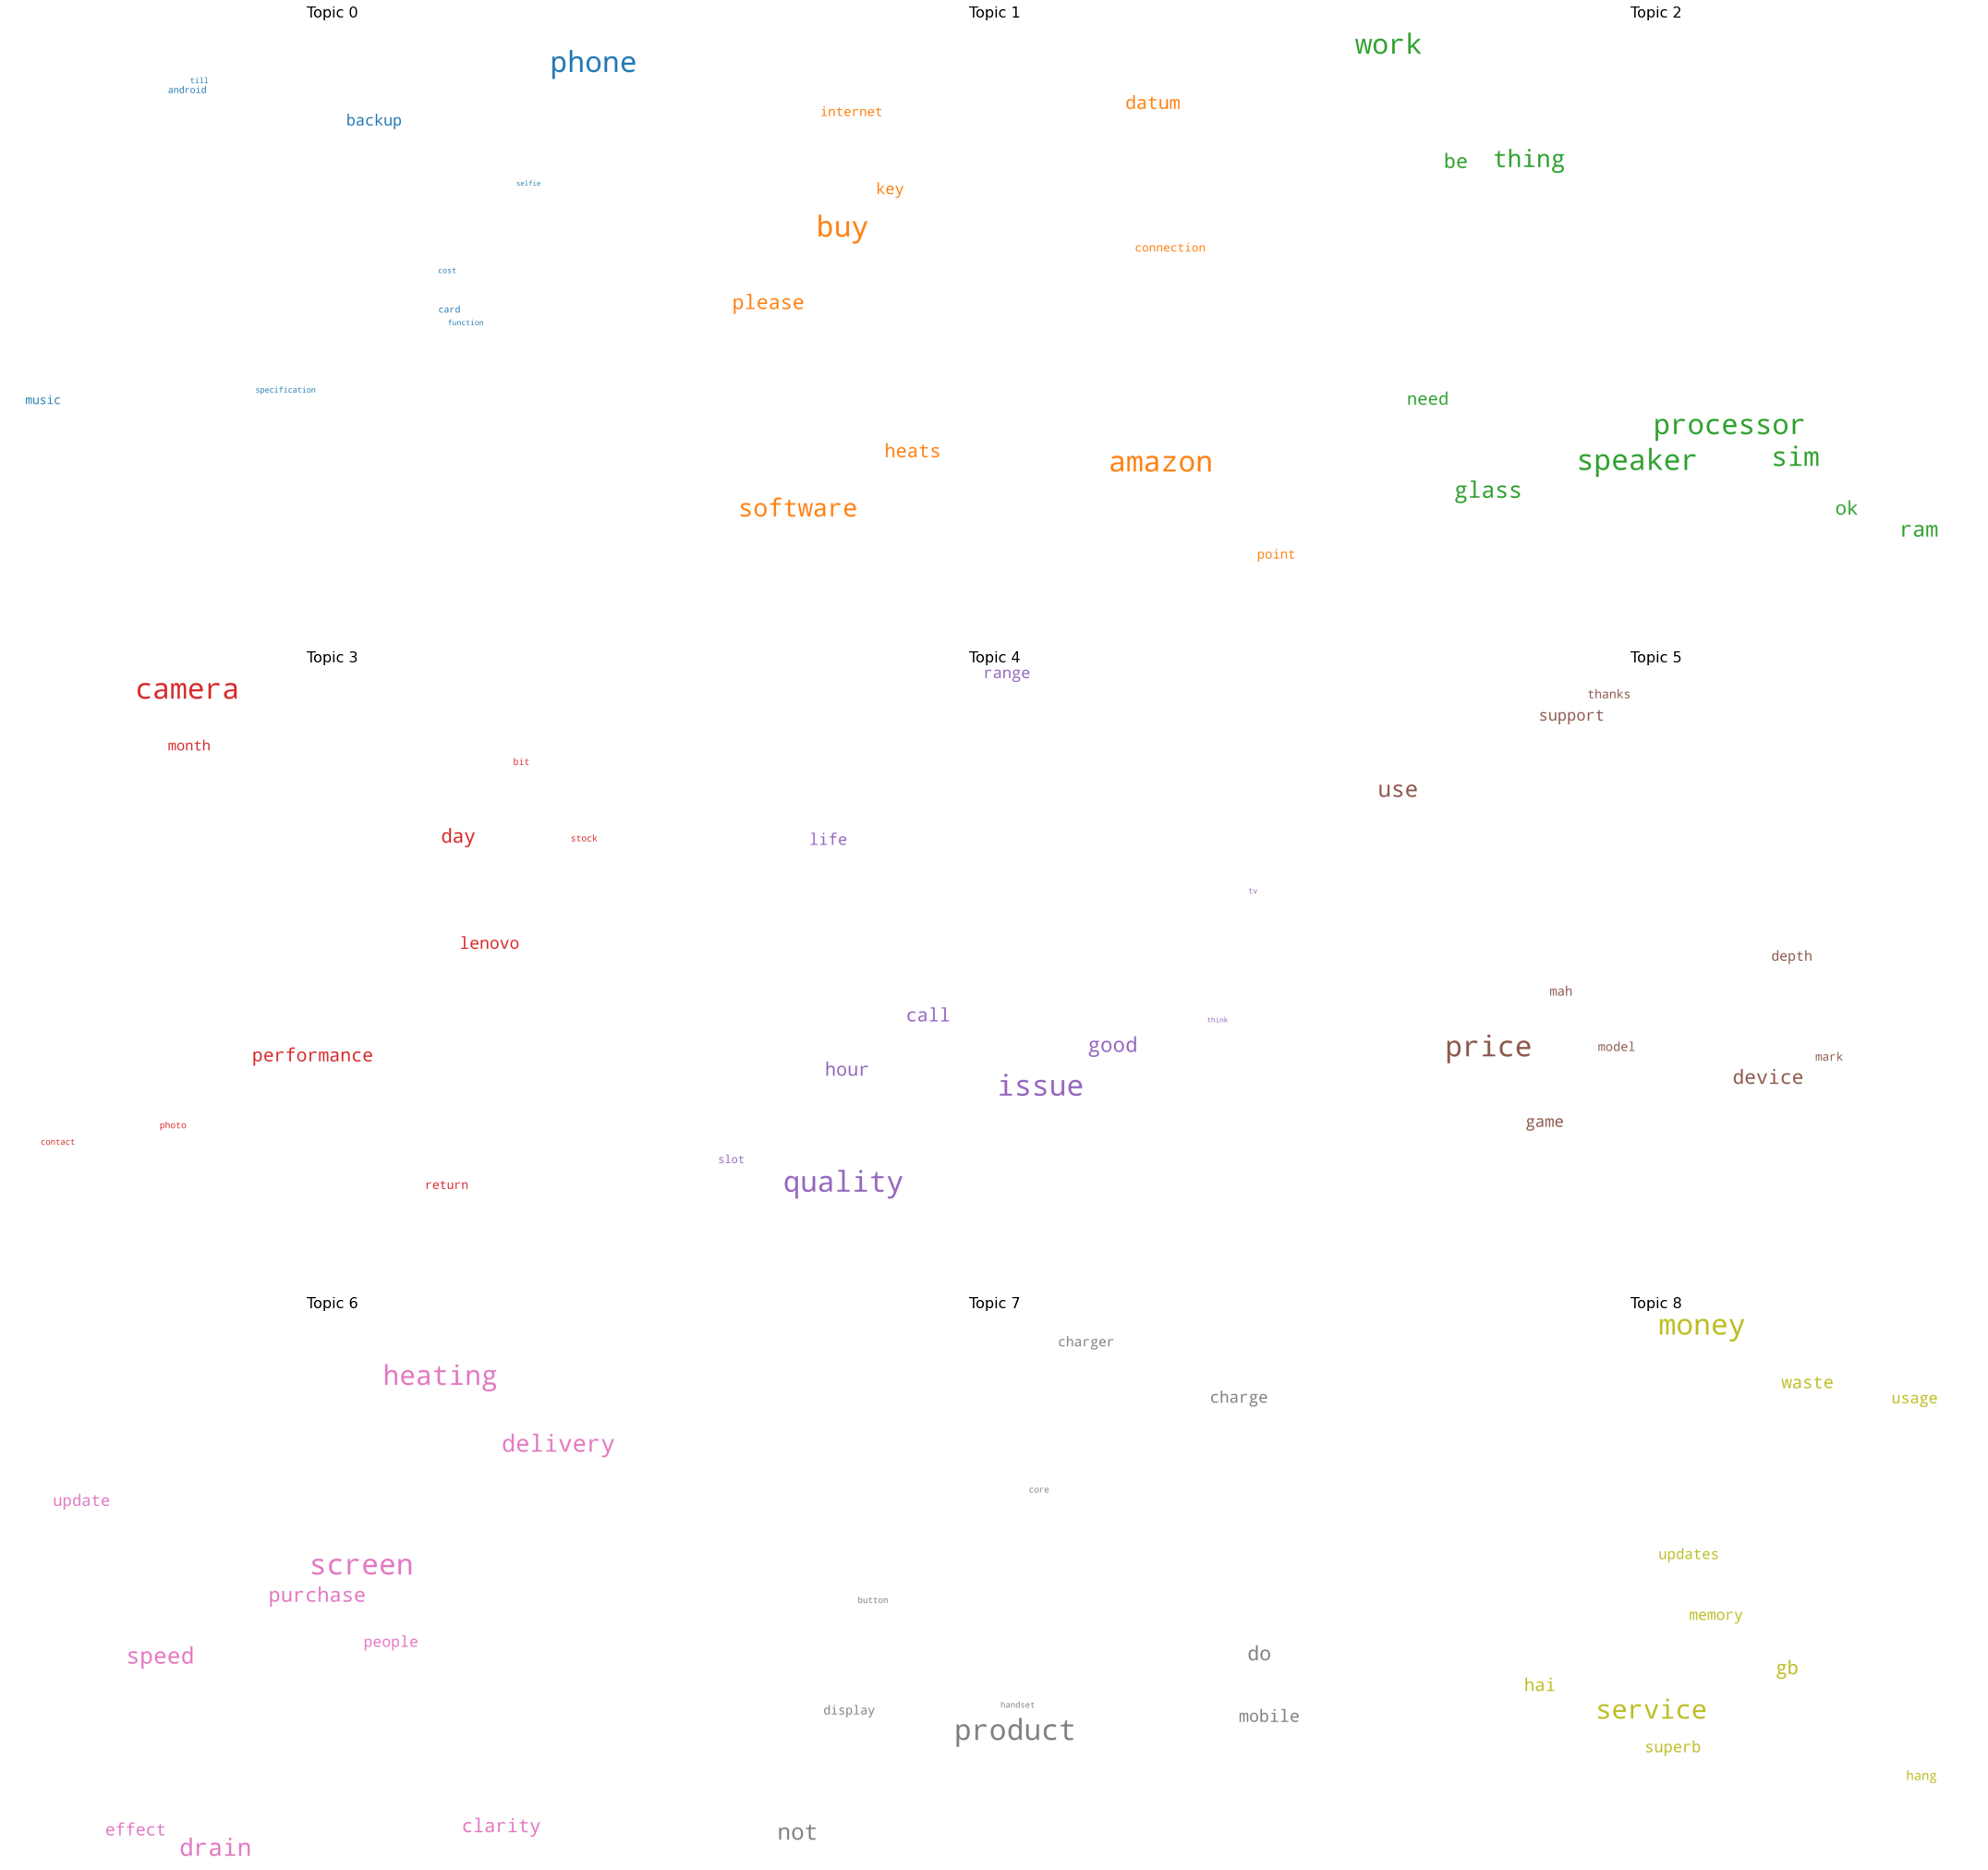

In [281]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=data_lemmatized,
                  background_color='white',
                  width=4500,
                  height=3800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_modelsh.show_topics(formatted=False) 
#topics=lda_model.show_topics(num_topics=-1, formatted=False)[i] = lda_model.show_topic(12 - i - 1)
fig, axes = plt.subplots(3, 3, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

# 8.2> What is the coherence of the model with the c_v metric?

In [282]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_modelsh, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8077801659412228


# 9> Analyze the topics through the business lens.
Determine which of the topics can be combined.
Ans:-
After analysing Topic Visualization graph and Topic_Perc_Contrib, I think Except topic numbers 1,2,3,4,9 rest all should be combined into one topic.
If circles r interconnected to each other, that means more preprocessing/EDA is required.

# 10> Create topic model using LDA with what you think is the optimal number of topics

GridSearch the best LDA model:-
The most important tuning parameter for LDA models is n_components (number of topics). Also learning_decay (which controls the learning rate) as well.

In [199]:
# Define Search Param
search_params = {'n_components': [4,6,8,10,12, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [4, 6, 8, 10, 12, 15, 20, 25, 30]})

Best topic model and its parameters:-

In [292]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_) # Best coherence score should be the bect_score_ and not log likeliho

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -69073.58627210274
Model Perplexity:  189.30411394376623


In [293]:
model.cv_results_['params'][0]

{'learning_decay': 0.5, 'n_components': 4}

In [294]:
model.cv_results_['params'], model.cv_results_['mean_test_score']

([{'learning_decay': 0.5, 'n_components': 4},
  {'learning_decay': 0.5, 'n_components': 6},
  {'learning_decay': 0.5, 'n_components': 8},
  {'learning_decay': 0.5, 'n_components': 10},
  {'learning_decay': 0.5, 'n_components': 12},
  {'learning_decay': 0.5, 'n_components': 15},
  {'learning_decay': 0.5, 'n_components': 20},
  {'learning_decay': 0.5, 'n_components': 25},
  {'learning_decay': 0.5, 'n_components': 30},
  {'learning_decay': 0.7, 'n_components': 4},
  {'learning_decay': 0.7, 'n_components': 6},
  {'learning_decay': 0.7, 'n_components': 8},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components': 12},
  {'learning_decay': 0.7, 'n_components': 15},
  {'learning_decay': 0.7, 'n_components': 20},
  {'learning_decay': 0.7, 'n_components': 25},
  {'learning_decay': 0.7, 'n_components': 30},
  {'learning_decay': 0.9, 'n_components': 4},
  {'learning_decay': 0.9, 'n_components': 6},
  {'learning_decay': 0.9, 'n_components': 8},
  {'learning_decay': 0

In [295]:
model.cv_results_['mean_test_score']

array([-69073.5862721 , -69535.0011234 , -69792.2046027 , -70019.07597711,
       -70291.76577639, -70729.68667887, -71141.44858489, -71310.20694118,
       -71854.00158247, -69090.99359013, -69423.84022719, -69742.22755825,
       -70073.51716631, -70256.22651991, -70643.05969883, -71130.6242901 ,
       -71512.73207658, -71888.41943008, -69086.24746979, -69425.50977166,
       -70014.65450542, -70032.7882099 , -70187.50852008, -70503.87274328,
       -71048.36472438, -71570.84348288, -72060.33227652])

In [296]:
model.best_params_

{'learning_decay': 0.5, 'n_components': 4}

# optimal number of topics=4

The below plot shows that coherence score decreases with the number of topics after 4, with a incline after 26. Topic coherence gives you a good picture so that you can take better decision.

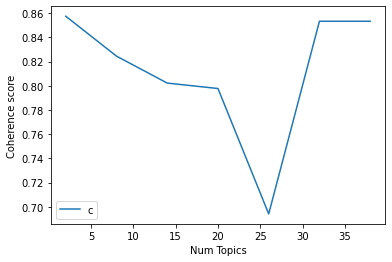

In [298]:
# Create a model list and plot Coherence score against a number of topics


#Using c_v Measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=doc_term_matrix, texts=data_lemmatized, start=2, limit=40, step=6)

# Try this function instead of above for better coherence score as u will see below my coherence score is not good.
# Also perform hyper parameter tuning for alpha and beta performed by sir in the program "NLP_Day5_topic-model-06-topic-coherence.ipynb"

#===========================================================================================================================

#def compute_coherence_values(corpus, dictionary, k, a, b):
    
#    lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=10, 
#                                           random_state=100,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha=a,
#                                           eta=b,
#                                           per_word_topics=True)
#    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
#    return coherence_model_lda.get_coherence()


#===========================================================================================================================
    



# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [299]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
topicnames

['Topic0', 'Topic1', 'Topic2', 'Topic3']

In [300]:
len(data)

14675

In [301]:
# index names
docnames = ["Doc" + str(i) for i in range(len(a))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
df_document_topic.head(5)

,Topic0,Topic1,Topic2,Topic3
Doc0,0.13,0.62,0.13,0.13
Doc1,0.13,0.62,0.13,0.13
Doc2,0.13,0.13,0.62,0.13
Doc3,0.62,0.13,0.13,0.13
Doc4,0.13,0.13,0.13,0.62


# 11> The business should  be able to interpret the topics.

In [302]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.130000,0.620000,0.130000,0.130000,1
Doc1,0.130000,0.620000,0.130000,0.130000,1
Doc2,0.130000,0.130000,0.620000,0.130000,2
Doc3,0.620000,0.130000,0.130000,0.130000,0
Doc4,0.130000,0.130000,0.130000,0.620000,3
Doc5,0.130000,0.620000,0.130000,0.130000,1
Doc6,0.250000,0.250000,0.250000,0.250000,0
Doc7,0.130000,0.130000,0.620000,0.130000,2
Doc8,0.130000,0.130000,0.130000,0.620000,3
Doc9,0.130000,0.620000,0.130000,0.130000,1


Review topics distribution across documents

In [303]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,36582
1,3,18889
2,1,13602
3,2,13601


In [304]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  27.505032
0        1.782994 -295.079681       2        1  25.885315
1      220.811432 -343.832123       3        1  23.305227
2       50.533993  -76.050934       4        1  23.304427, topic_info=          Term         Freq        Total Category  logprob  loglift
409      phone  5960.000000  5960.000000  Default  30.0000  30.0000
68      camera  2438.000000  2438.000000  Default  29.0000  29.0000
448    product  2099.000000  2099.000000  Default  28.0000  28.0000
35     battery  2259.000000  2259.000000  Default  27.0000  27.0000
442    problem  1594.000000  1594.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
14        apps   137.765367   138.499152   Topic4  -4.6679   1.4512
100    company   135.633590   136.367375   Topic4  -4.6835   1.4511
238  headphone   124.974704   125.708490   Topic4  -4.7653   1.4507
74        care   122.842927   123.576713   Topic4  -4.7825   1.4506
601     update   122.842927   123.576713   Topic4  -4.7825   1.4506

[150 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         4  0.998779       amazon
10        2  0.995040      android
12        4  0.995075          app
13        2  0.988723  application
14        4  0.996396         apps
...     ...       ...          ...
613       1  0.994698        video
618       3  0.991408       volume
623       4  0.997119        waste
627       4  0.996845         week
634       2  0.995986         work

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [305]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index   = topicnames

# View
df_topic_keywords.head()

,aap,access,accessory,account,action,activity,airtel,alarm,amazon,amazone,...,wise,word,work,world,worth,wrost,year,yesterday,youtube,zoom
Topic0,0.250307,0.250220,0.250305,0.250223,0.250221,0.250309,0.250220,0.250307,0.250217,0.250308,...,45.249091,28.249088,304.249095,0.250221,0.250218,11.249075,79.249093,29.249088,0.250219,0.250220
Topic1,0.250380,0.250273,0.250378,0.250275,0.250274,0.250382,0.250273,0.250380,0.250269,0.250381,...,0.250334,0.250335,0.250332,0.250273,0.250270,0.250340,0.250333,0.250335,0.250271,0.250272
Topic2,0.250380,16.249310,0.250378,10.249303,13.249307,0.250382,17.249311,0.250380,480.249321,0.250381,...,0.250334,0.250335,0.250332,15.249309,40.249317,0.250340,0.250333,0.250335,27.249314,18.249311
Topic3,12.248932,0.250197,18.248940,0.250199,0.250198,10.248927,0.250197,13.248934,0.250194,11.248930,...,0.250241,0.250242,0.250240,0.250197,0.250195,0.250245,0.250240,0.250242,0.250196,0.250196


In [306]:

# Remove Stop Words
data_words = remove_stopwords(data_words)

# Form Bigrams
data_words = make_bigrams(data_words)

# Do lemmatization keeping only Noun, Adj, Verb, Adverb

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

data_lemmatized1 = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
while("" in data_lemmatized1) : 
    data_lemmatized1.remove("") 
#data_lemmatized1
import gensim
from gensim import corpora
#id2word = Dictionary.id2token
data_lemmatized1 = [d.split() for d in data_lemmatized1]
id2word = corpora.Dictionary(data_lemmatized1)
doc_term_matrix = [id2word.doc2bow(rev) for rev in (data_lemmatized1[:])]
LDA = gensim.models.ldamodel.LdaModel

best_lda_model = LDA(corpus=doc_term_matrix, id2word=id2word, num_topics=4, random_state=100)
                #chunksize=1000, passes=50))              
print(best_lda_model.print_topics())


[(0, '0.090*"note" + 0.064*"feature" + 0.046*"money" + 0.043*"charge" + 0.038*"service" + 0.038*"hour" + 0.025*"software" + 0.018*"lot" + 0.014*"value" + 0.013*"front"'), (1, '0.362*"phone" + 0.078*"issue" + 0.077*"quality" + 0.048*"performance" + 0.028*"month" + 0.020*"option" + 0.020*"heating" + 0.015*"delivery" + 0.014*"music" + 0.013*"speed"'), (2, '0.150*"camera" + 0.133*"battery" + 0.107*"product" + 0.079*"problem" + 0.052*"day" + 0.051*"time" + 0.048*"price" + 0.027*"use" + 0.026*"network" + 0.026*"buy"'), (3, '0.045*"good" + 0.036*"call" + 0.031*"nice" + 0.030*"charger" + 0.025*"life" + 0.024*"heat" + 0.024*"processor" + 0.023*"work" + 0.022*"drain" + 0.018*"game"')]


# 11.1> Name each of the identified topics.

Topic 0: probably price of the device
Topic 1: probably heating problem
Topic 2: probably day time camera problem
Topic 3: probably good charger

In [307]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_lda_model, doc_term_matrix, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.349888  0.186785       1        1  27.660982
1      0.297467  0.259072       2        1  26.852460
0      0.027104 -0.236999       3        1  22.778099
3      0.025317 -0.208859       4        1  22.708459, topic_info=        Term         Freq        Total Category  logprob  loglift
9      phone  5620.000000  5620.000000  Default  30.0000  30.0000
42    camera  2403.000000  2403.000000  Default  29.0000  29.0000
5    battery  2122.000000  2122.000000  Default  28.0000  28.0000
34   product  1705.000000  1705.000000  Default  27.0000  27.0000
15      note  1186.000000  1186.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
162     hand    81.684334    82.395262   Topic4  -5.0787   1.4738
454      cam    77.430953    78.136554   Topic4  -5.1322   1.4734
117  request    77.141617    77.847499   Topic4  -5.1359   1.4733
277     rear    71.255773    71.961679   Topic4  -5.2153   1.4726
690     face    71.002123    71.709714   Topic4  -5.2189   1.4725

[150 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
355       1  0.991047  application
180       3  0.995945         auto
182       4  0.991358      average
239       3  0.993202      awesome
5         1  0.999720      battery
...     ...       ...          ...
332       4  0.996465        video
273       1  0.988396       volume
354       1  0.989831         week
79        4  0.998729         work
20        3  0.988116         year

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [308]:
def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=data_lemmatized1):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_lda_model, corpus=doc_term_matrix, texts=data_lemmatized1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6250,"good, call, nice, charger, life, heat, processor, work, drain, game",[need]
1,1,3.0,0.6250,"good, call, nice, charger, life, heat, processor, work, drain, game",[improvement]
2,2,0.0,0.6250,"note, feature, money, charge, service, hour, software, lot, value, front",[hour]
3,3,2.0,0.6250,"camera, battery, product, problem, day, time, price, use, network, buy",[use]
4,4,1.0,0.6221,"phone, issue, quality, performance, month, option, heating, delivery, music, speed",[lie]
5,5,2.0,0.6250,"camera, battery, product, problem, day, time, price, use, network, buy",[battery]
6,6,3.0,0.6250,"good, call, nice, charger, life, heat, processor, work, drain, game",[charger]
7,7,0.0,0.6250,"note, feature, money, charge, service, hour, software, lot, value, front",[hour]
8,8,3.0,0.6250,"good, call, nice, charger, life, heat, processor, work, drain, game",[cash]
9,9,3.0,0.6250,"good, call, nice, charger, life, heat, processor, work, drain, game",[good]


# 11.2> Create a table with the topic name and the top 10 terms/keywords in each topic to present to the  business.

In [309]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.625,"note, feature, money, charge, service, hour, software, lot, value, front",[hour]
1,1.0,0.625,"phone, issue, quality, performance, month, option, heating, delivery, music, speed",[check]
2,2.0,0.625,"camera, battery, product, problem, day, time, price, use, network, buy",[use]
3,3.0,0.625,"good, call, nice, charger, life, heat, processor, work, drain, game",[need]


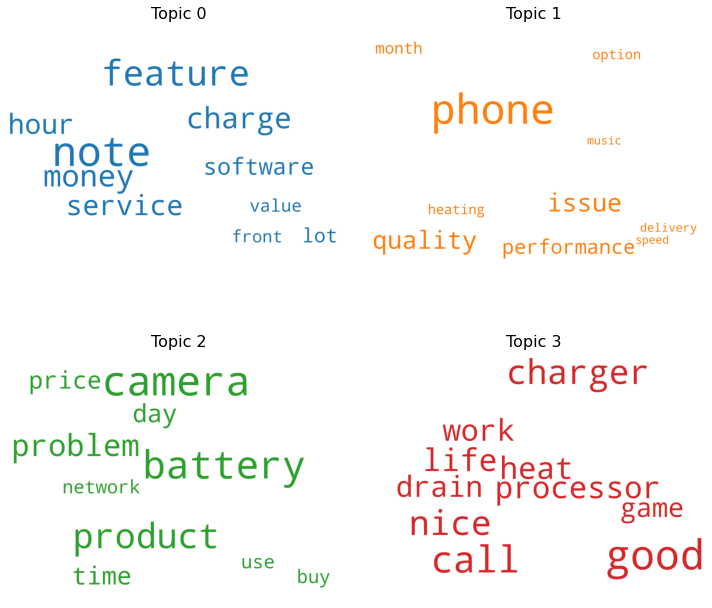

In [310]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=data_lemmatized1,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = best_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


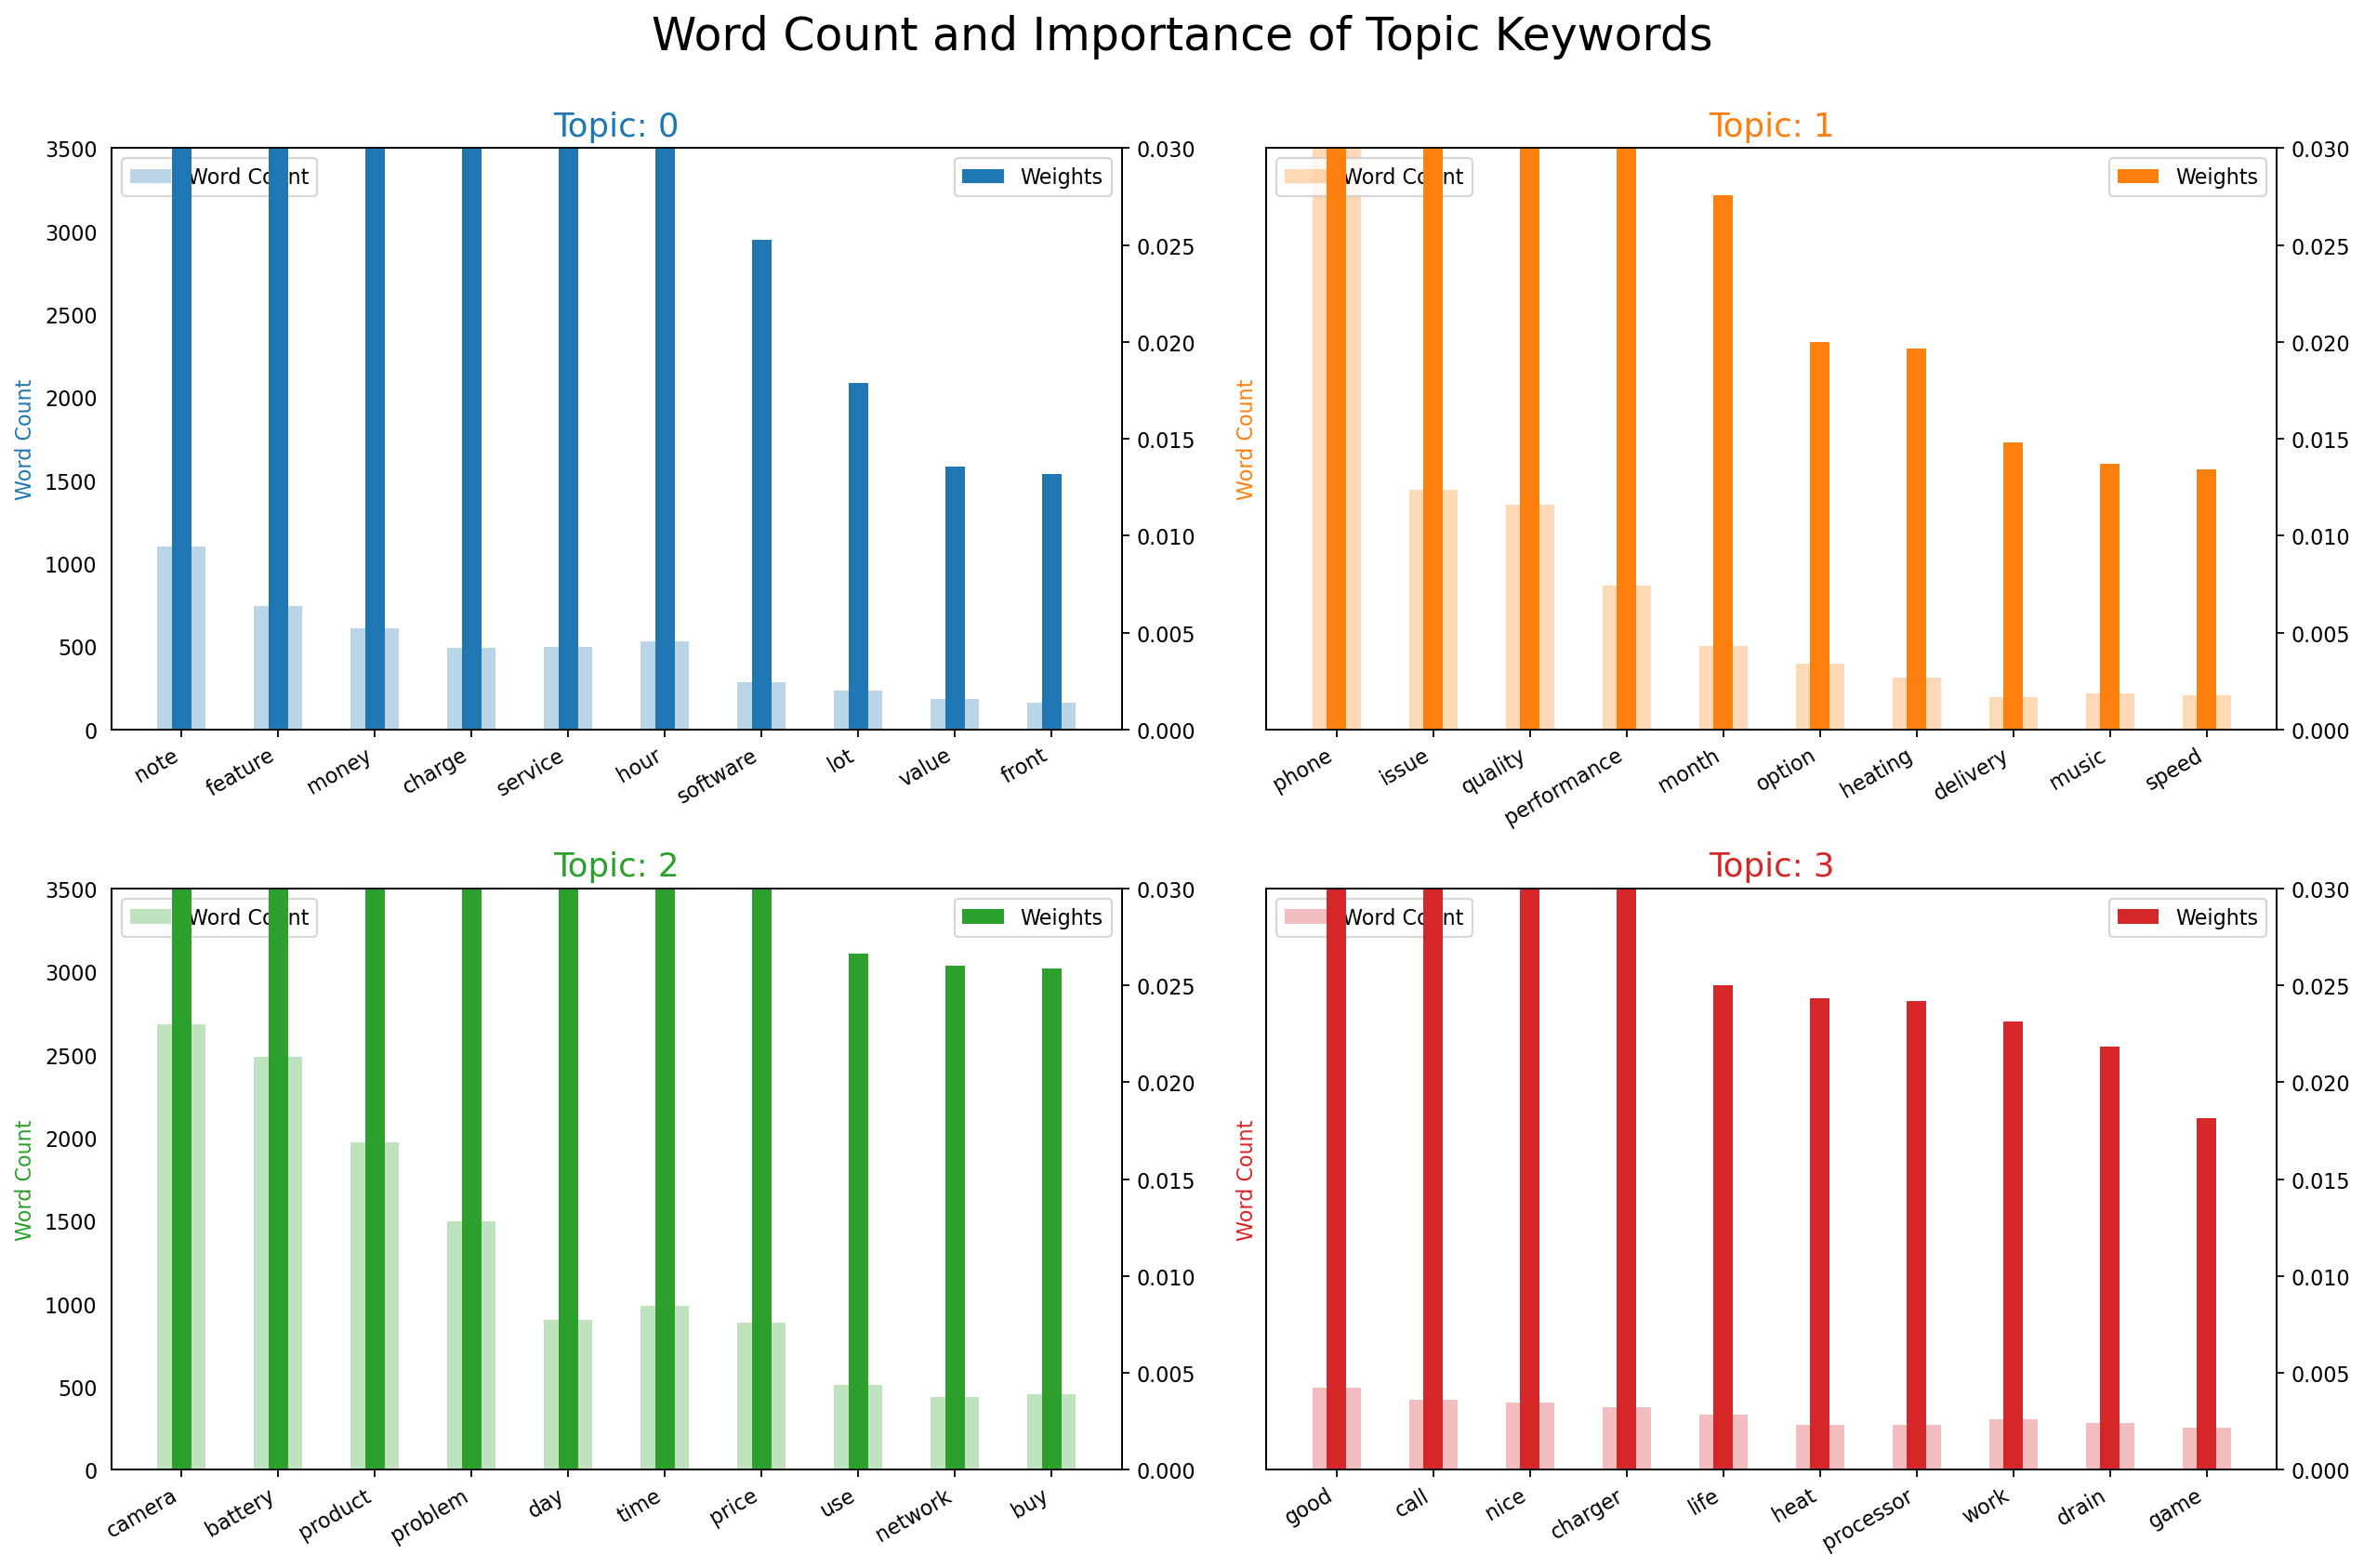

In [311]:
from collections import Counter
topics = best_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized1 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# 10.1> What is the coherence of the model of the best model which I got after applying GridSearch?

In [312]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=best_lda_model, texts=data_lemmatized1, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8428518421119008


topic coherence score .3 is bad, .4 is low, .55 is ok, .65 might be as good as it is going to get, .7 is nice, .8 is unlikely
and .9 is probably wrong.
I will have to work on "no. of topics", preprocessing as things r not nice for me here.
Approach for topic model should be:
1> preprocessing, 
2> configure ur gensim, 
3> optimize ur gensim for right no. of topics and alpha,beta. Tune them and commission it.
4> now u r ready with ur topic model and do analysis what r 10 topics for the document, what r top 10 keywords for the topic,
how is the topic distributed across the document

In [313]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=best_lda_model, texts=data_lemmatized1, dictionary=id2word, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -22.786320169280174


do this assignment again by following.
Approach for topic model should be:
1> preprocessing, 
2> configure ur gensim, 
3> optimize ur gensim for right no. of topics and alpha,beta. Tune them and commission it.
4> now u r ready with ur topic model and do analysis what r 10 topics for the document, what r top 10 keywords for the topic,
how is the topic distributed across the document

refer progs:
NLP_Day5_topic-model-07-LDA-newsgroups-CV.ipynb
NLP_Day5_topic-model-06-topic-coherence.ipynb